--- Starting Figure Generation ---

Loading Plowman data...
Loading data from ../data/PLOWMAN/03_morphometrics_output/original_pca_scores_and_class_labels.h5
Loading PCA parameters from ../data/PLOWMAN/03_morphometrics_output/leaf_pca_model_parameters.h5
Calculating average shapes per class...
Data loaded and average shapes calculated for ../data/PLOWMAN/

Loading Cultivated1st data...
Loading data from ../data/CULTIVATED1ST/03_morphometrics_output_cultivated1st/original_pca_scores_and_class_labels.h5
Loading PCA parameters from ../data/CULTIVATED1ST/03_morphometrics_output_cultivated1st/leaf_pca_model_parameters.h5
Calculating average shapes per class...
Data loaded and average shapes calculated for ../data/CULTIVATED1ST/

Plowman: 84 components
Cultivated1st: 198 components
Proceeding by using only the first 2 PCs for global limits and plotting.

Global PC1 Limits: (-0.18, 0.24)
Global PC2 Limits: (-0.08, 0.12)
Dynamically calculated HEIGHT_PER_MORPHOSPACE_PANEL_INCHES: 3.56 inches
R

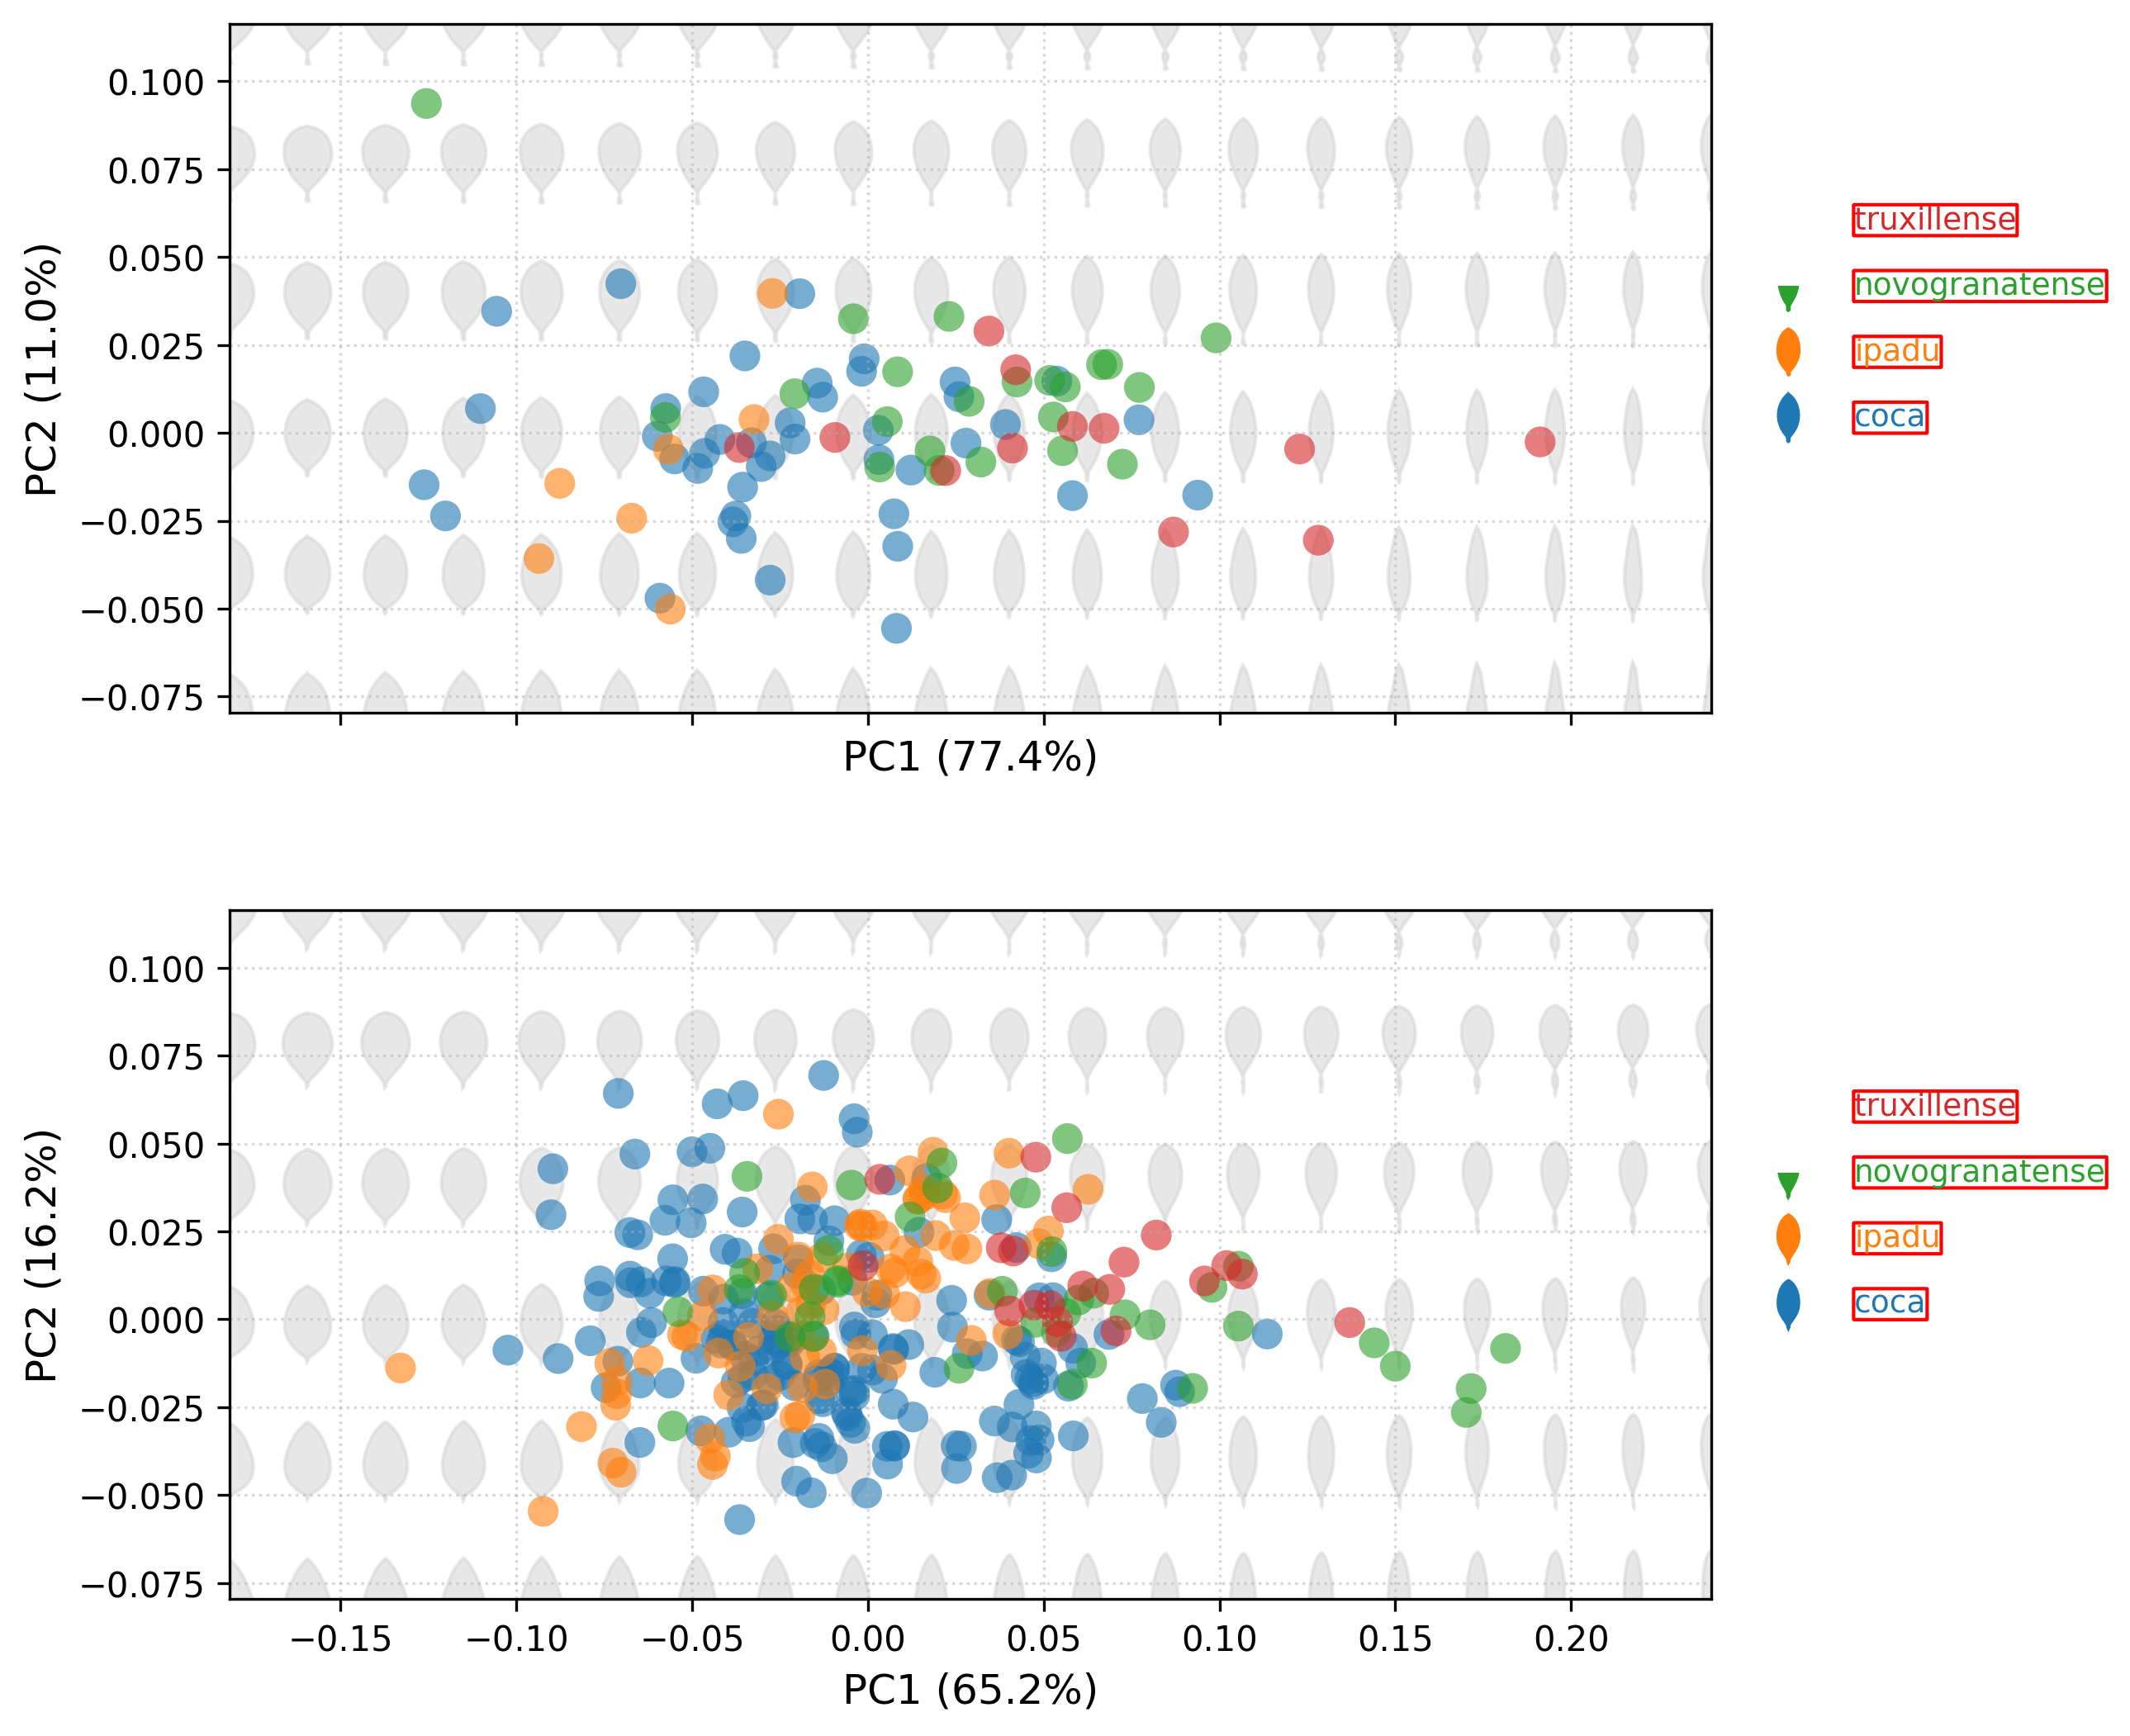

--- Figure Generation Complete ---


In [52]:
#######################
### LOAD IN MODULES ###
#######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os

# Ensure consistent plotting style for publication
plt.style.use('seaborn-v0_8-deep')

############################
### GLOBAL CONFIGURATION ###
############################

# --- File Paths ---
PLOWMAN_BASE_DIR = "../data/PLOWMAN/"
CULTIVATED1ST_BASE_DIR = "../data/CULTIVATED1ST/"

MORPHOMETRICS_OUTPUT_SUBDIR_PLOWMAN = "03_morphometrics_output/"
MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST = "03_morphometrics_output_cultivated1st/"

PCA_PARAMS_FILENAME = "leaf_pca_model_parameters.h5"
PCA_SCORES_LABELS_FILENAME = "original_pca_scores_and_class_labels.h5"

# Output directory for figures
FIGURES_OUTPUT_DIR = "../figures/"
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

# --- Figure Parameters ---
PAGE_WIDTH_INCHES = 8.5
DPI = 300

# NUM_MORPHOSPACES is a constant
NUM_MORPHOSPACES = 2 

# HEIGHT_PER_MORPHOSPACE_PANEL_INCHES will be calculated dynamically
# FIGURE_HEIGHT_INCHES will then be calculated from it.

# General font sizes
TITLE_FONTSIZE = 14
AXIS_LABEL_FONTSIZE = 12
AXIS_TICK_FONTSIZE = 10
LEGEND_FONTSIZE = 10
SHAPE_LABEL_FONTSIZE = 9

# --- Plotting Specifics for Morphospace ---
EIGENLEAF_SCALE_FACTOR = 0.08
EIGENLEAF_COLOR = "lightgray"
EIGENLEAF_ALPHA = 0.5
POINT_SIZE = 80
POINT_ALPHA = 0.6
POINT_LINEWIDTH = 0

# Legend specific parameters
LEGEND_LEAF_SCALE_FACTOR = 0.15 # Kept this as it seemed to be working for size
# MODIFIED: Adjusted VERTICAL_LEGEND_ITEM_HEIGHT_NORM to allow more vertical space for leaves
VERTICAL_LEGEND_ITEM_HEIGHT_NORM = 0.4 # Reduced from 0.4 to ensure all 4 leaves fit

shape_start_x_norm = 0.15 
text_offset_x_norm = 0.40

# Consistent colors for the 4 main classes
CLASS_COLORS = {
    'coca': 'tab:blue',
    'ipadu': 'tab:orange',
    'novogranatense': 'tab:green',
    'truxillense': 'tab:red'
}

# Number of landmarks and dimensions
NUM_LANDMARKS = (50 * 2) - 1
NUM_DIMENSIONS = 2

# NEW: Margin factor for plots to prevent clipping of points/eigenleaves
PLOT_MARGIN_FACTOR = 0.15 

#########################
### HELPER FUNCTIONS ###
#########################

def load_morphometrics_data(base_dir, morphometrics_subdir):
    """
    Loads PCA scores, class labels, original flattened coordinates,
    and PCA model parameters for a given dataset, and calculates
    average shapes per class.
    """
    output_dir = os.path.join(base_dir, morphometrics_subdir)
    
    pca_scores_labels_path = os.path.join(output_dir, PCA_SCORES_LABELS_FILENAME)
    pca_params_path = os.path.join(output_dir, PCA_PARAMS_FILENAME)

    data = {}

    print(f"Loading data from {pca_scores_labels_path}")
    with h5py.File(pca_scores_labels_path, 'r') as f:
        data['pc_scores'] = f['pca_scores'][:]
        data['class_labels'] = f['class_labels'][:].astype(str)
        data['original_flattened_coords'] = f['original_flattened_coords'][:]

    print(f"Loading PCA parameters from {pca_params_path}")
    with h5py.File(pca_params_path, 'r') as f:
        data['pca_components'] = f['components'][:]
        data['pca_mean'] = f['mean'][:]
        data['pca_explained_variance_ratio'] = f['explained_variance_ratio'][:]
        data['num_pca_components'] = f.attrs['n_components']

    data['num_dimensions'] = NUM_DIMENSIONS
    data['num_landmarks'] = data['original_flattened_coords'].shape[1] // data['num_dimensions']
    
    print("Calculating average shapes per class...")
    average_shapes = {}
    unique_classes = np.unique(data['class_labels'])
    
    for cls in unique_classes:
        class_indices = (data['class_labels'] == cls)
        class_coords_flat = data['original_flattened_coords'][class_indices]
        class_coords_3d = class_coords_flat.reshape(-1, data['num_landmarks'], data['num_dimensions'])
        avg_shape = np.mean(class_coords_3d, axis=0)
        average_shapes[cls] = avg_shape
        
    data['average_shapes_by_class'] = average_shapes
    
    print(f"Data loaded and average shapes calculated for {base_dir}")
    return data

def plot_morphospace_panel(ax_main, ax_legend, data, title, class_colors, global_pc_limits=None):
    """
    Plots a single morphospace panel including scatter plot, eigenleaf grid,
    and average shapes as a legend.
    """
    # Scatter plot
    sns.scatterplot(
        x=data['pc_scores'][:, 0], y=data['pc_scores'][:, 1],
        hue=data['class_labels'],
        palette=class_colors,
        s=POINT_SIZE, linewidth=POINT_LINEWIDTH, alpha=POINT_ALPHA,
        ax=ax_main,
        legend=False
    )

    # Set consistent axis limits if provided
    if global_pc_limits:
        ax_main.set_xlim(global_pc_limits['pc1_min'], global_pc_limits['pc1_max'])
        ax_main.set_ylim(global_pc_limits['pc2_min'], global_pc_limits['pc2_max'])

    # Calculate min/max for PC1/PC2 for inverse eigenleaf grid based on *actual plotted limits*
    # This ensures eigenleaves fill the visible area
    pc1_min, pc1_max = ax_main.get_xlim()
    pc2_min, pc2_max = ax_main.get_ylim()

    # Create PC intervals for plotting inverse eigenleaves
    MORPHOSPACE_PC1_INTERVALS = 20
    MORPHOSPACE_PC2_INTERVALS = 6

    PC1_vals = np.linspace(pc1_min, pc1_max, MORPHOSPACE_PC1_INTERVALS)
    PC2_vals = np.linspace(pc2_min, pc2_max, MORPHOSPACE_PC2_INTERVALS)

    # Plot inverse eigenleaves (the background grid shapes)
    pca_components_2d = data['pca_components'][:2, :]
    pca_mean_flat = data['pca_mean']

    for i in PC1_vals:
        for j in PC2_vals:
            reconstructed_flat_shape = (np.array([i, j]) @ pca_components_2d) + pca_mean_flat
            reconstructed_shape_2d = reconstructed_flat_shape.reshape(data['num_landmarks'], data['num_dimensions'])
            ax_main.fill(reconstructed_shape_2d[:, 0] * EIGENLEAF_SCALE_FACTOR + i,
                         reconstructed_shape_2d[:, 1] * EIGENLEAF_SCALE_FACTOR + j,
                         color=EIGENLEAF_COLOR, alpha=EIGENLEAF_ALPHA, zorder=-1)

    # Set axis labels with explained variance from the first two PCs
    exp_var_pc1 = data['pca_explained_variance_ratio'][0] * 100
    exp_var_pc2 = data['pca_explained_variance_ratio'][1] * 100
    
    ax_main.set_xlabel(f"PC1 ({exp_var_pc1:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.set_ylabel(f"PC2 ({exp_var_pc2:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.set_aspect('equal', adjustable='box') # Keep adjustable='box' to maintain data aspect
    ax_main.set_facecolor('white')
    ax_main.grid(True, linestyle=':', alpha=0.5)


    # --- Plotting Average Shapes as Legend ---
    ax_legend.clear() 
    ax_legend.set_axis_off()

    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, 1)

    legend_class_order = ['coca', 'ipadu', 'novogranatense', 'truxillense']
    present_classes = [cls for cls in legend_class_order if cls in data['average_shapes_by_class']]

    num_avg_shapes = len(present_classes)
    if num_avg_shapes > 0:
        max_extent_across_all_avg_shapes = 0
        for cls_name in present_classes:
            avg_shape_coords_current = data['average_shapes_by_class'][cls_name]
            centered_shape_current = avg_shape_coords_current - np.mean(avg_shape_coords_current, axis=0) # Centering to get max extent from origin
            max_extent_across_all_avg_shapes = max(max_extent_across_all_avg_shapes,
                                                   np.max(np.abs(centered_shape_current)))
        
        if max_extent_across_all_avg_shapes == 0:
            max_extent_across_all_avg_shapes = 1

        # Use the height norm directly for item spacing
        vertical_item_height_norm = VERTICAL_LEGEND_ITEM_HEIGHT_NORM

        # Calculate starting Y position to center the block of legend items
        # MODIFIED: Adjusted this calculation to ensure items are better centered within the legend axis
        total_block_height_normalized = num_avg_shapes * vertical_item_height_norm
        # Ensure that the starting position leaves enough room at the top for the first leaf,
        # considering the leaf's height extends both above and below its center point.
        # This simple centering might need more fine-tuning if leaves are very tall relative to item_height.
        # However, by reducing vertical_item_height_norm, we create more space.
        start_y_position = (1.0 - total_block_height_normalized) / 2.0 if total_block_height_normalized < 1.0 else 0.0
        
        for i, cls_name in enumerate(present_classes):
            avg_shape_coords = data['average_shapes_by_class'][cls_name]
            color = class_colors.get(cls_name, 'black')

            normalized_shape = avg_shape_coords - np.mean(avg_shape_coords, axis=0) # Re-center for scaling consistency
            scaled_shape_for_legend = (normalized_shape / max_extent_across_all_avg_shapes) * LEGEND_LEAF_SCALE_FACTOR

            shape_center_y_norm = start_y_position + (i + 0.5) * vertical_item_height_norm
            
            # Position within the legend axis (using normalized coordinates 0-1)
            
            # Add class name text next to the shape (plot first, with lower zorder)
            ax_legend.text(shape_start_x_norm + text_offset_x_norm,
                           shape_center_y_norm,
                           cls_name,
                           color=color,
                           fontsize=SHAPE_LABEL_FONTSIZE,
                           ha='left', va='center',
                           transform=ax_legend.transAxes,
                           bbox=dict(facecolor='white', alpha=1.0, edgecolor='red', boxstyle='round,pad=0.02'), # Added edgecolor='red' for debugging
                           zorder=5) # Explicitly lower zorder for text and its bbox

            # Plot the leaf shape with a high zorder so it's not obscured by text background
            ax_legend.fill(scaled_shape_for_legend[:, 0] + shape_start_x_norm,
                           scaled_shape_for_legend[:, 1] + shape_center_y_norm,
                           color=color, zorder=10, # Higher zorder for shapes
                           transform=ax_legend.transAxes)

    ax_legend.set_aspect('equal', adjustable='box')


##########################
### MAIN FIGURE SCRIPT ###
##########################

print("--- Starting Figure Generation ---")

# 1. Load Data for Plowman
print("\nLoading Plowman data...")
plowman_data = load_morphometrics_data(PLOWMAN_BASE_DIR, MORPHOMETRICS_OUTPUT_SUBDIR_PLOWMAN)

# 2. Load Data for Cultivated1st
print("\nLoading Cultivated1st data...")
cultivated1st_data = load_morphometrics_data(CULTIVATED1ST_BASE_DIR, MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST)

# --- Check for consistent PCA components (informational) ---
if plowman_data['num_pca_components'] != cultivated1st_data['num_pca_components']:
    print(f"\nWARNING: Number of PCA components differ between datasets!")
    print(f"Plowman: {plowman_data['num_pca_components']} components")
    print(f"Cultivated1st: {cultivated1st_data['num_pca_components']} components")
    print(f"Proceeding by using only the first 2 PCs for global limits and plotting.")


# --- Calculate Global PC Limits for consistent plot scaling ---
# Select only the first 2 principal components before stacking
all_pc_scores = np.vstack((plowman_data['pc_scores'][:, :2], cultivated1st_data['pc_scores'][:, :2]))

# Calculate raw min/max
global_pc1_min_raw, global_pc1_max_raw = all_pc_scores[:, 0].min(), all_pc_scores[:, 0].max()
global_pc2_min_raw, global_pc2_max_raw = all_pc_scores[:, 1].min(), all_pc_scores[:, 1].max()

# Calculate ranges
global_pc1_range = global_pc1_max_raw - global_pc1_min_raw
global_pc2_range = global_pc2_max_raw - global_pc2_min_raw

# Apply margin to expand limits
global_pc_limits = {
    'pc1_min': global_pc1_min_raw - global_pc1_range * PLOT_MARGIN_FACTOR,
    'pc1_max': global_pc1_max_raw + global_pc1_range * PLOT_MARGIN_FACTOR,
    'pc2_min': global_pc2_min_raw - global_pc2_range * PLOT_MARGIN_FACTOR,
    'pc2_max': global_pc2_max_raw + global_pc2_range * PLOT_MARGIN_FACTOR
}

print(f"\nGlobal PC1 Limits: ({global_pc_limits['pc1_min']:.2f}, {global_pc_limits['pc1_max']:.2f})")
print(f"Global PC2 Limits: ({global_pc_limits['pc2_min']:.2f}, {global_pc_limits['pc2_max']:.2f})")

# --- Dynamically adjust panel height to match data aspect ratio ---
# Calculate the aspect ratio of the data's range in the morphospace
# Use the *raw* limits for aspect ratio calculation, as this reflects the data's true spread
data_aspect_ratio = (global_pc1_max_raw - global_pc1_min_raw) / \
                    (global_pc2_max_raw - global_pc2_min_raw)

# The main plot takes up MAIN_PLOT_WIDTH_RATIO of the PAGE_WIDTH_INCHES.
MAIN_PLOT_WIDTH_RATIO = 0.9 
HEIGHT_PER_MORPHOSPACE_PANEL_INCHES = (MAIN_PLOT_WIDTH_RATIO * PAGE_WIDTH_INCHES) / data_aspect_ratio

# Update FIGURE_HEIGHT_INCHES based on the new dynamically calculated panel height
FIGURE_HEIGHT_INCHES = NUM_MORPHOSPACES * HEIGHT_PER_MORPHOSPACE_PANEL_INCHES

print(f"Dynamically calculated HEIGHT_PER_MORPHOSPACE_PANEL_INCHES: {HEIGHT_PER_MORPHOSPACE_PANEL_INCHES:.2f} inches")
print(f"Resulting FIGURE_HEIGHT_INCHES (excluding padding): {FIGURE_HEIGHT_INCHES:.2f} inches")


# 3. Define Figure Layout using GridSpec
fig = plt.figure(figsize=(PAGE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES), dpi=DPI,
                 constrained_layout=True)

# Set padding for constrained_layout AFTER figure creation
fig.set_constrained_layout_pads(w_pad=0.05, h_pad=0.15, wspace=0.05, hspace=0.15) 

# Define the overall GridSpec for the figure
gs = fig.add_gridspec(NUM_MORPHOSPACES, 2,
                  width_ratios=[MAIN_PLOT_WIDTH_RATIO, 0.1],
                  height_ratios=[1]*NUM_MORPHOSPACES
                 )

# 4. Plot Plowman Morphospace
print("\nPlotting Plowman morphospace...")
# Added sharex and sharey to force consistent axis limits and alignment
ax_plowman_main = fig.add_subplot(gs[0, 0])
ax_plowman_legend = fig.add_subplot(gs[0, 1])

plot_morphospace_panel(ax_plowman_main, ax_plowman_legend, plowman_data,
                       title="Plowman Dataset Morphospace",
                       class_colors=CLASS_COLORS,
                       global_pc_limits=global_pc_limits)

# 5. Plot Cultivated1st Morphospace
print("Plotting Cultivated1st morphospace...")
# Shared axes with the Plowman plot for consistent scaling and alignment
ax_cultivated1st_main = fig.add_subplot(gs[1, 0], sharex=ax_plowman_main, sharey=ax_plowman_main)
ax_cultivated1st_legend = fig.add_subplot(gs[1, 1])

plot_morphospace_panel(ax_cultivated1st_main, ax_cultivated1st_legend, cultivated1st_data,
                       title="Cultivated1st Dataset Morphospace",
                       class_colors=CLASS_COLORS,
                       global_pc_limits=global_pc_limits)

# Ensure tick labels are only on the bottom-most x-axis for shared axes
plt.setp(ax_plowman_main.get_xticklabels(), visible=False)


# 6. Final Adjustments and Saving
output_filename = "Combined_Morphospaces.png"

plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, output_filename), dpi=DPI, bbox_inches='tight')
print(f"\nFigure saved to: {os.path.join(FIGURES_OUTPUT_DIR, output_filename)}")

plt.show()
print("--- Figure Generation Complete ---")